In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
import gpytorch
from gpytorch.functions import pivoted_cholesky

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from LBFGS import LBFGS

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions

# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2
train_x, train_y, test_x, test_y = fetch_uci_dataset('bike',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=9/10,val_frac=0)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print(train_x.shape)


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
SIZE (16599, 19)
Dataset loaded
torch.Size([14939, 17])


In [2]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import gpytorch

def run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5,
        compute_covariance=False
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    gpr = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)
    
    start_fit = time.time()
    gpr.fit(train_x, train_y)
    chol_fit_time = time.time() - start_fit

    start_pred = time.time()
    chol_mean, GP_covariance = gpr.predict(test_x)
    chol_pred_time = time.time() - start_pred

    start_mll = time.time()
    chol_mll_value = gpr.compute_mll(train_y)
    chol_mll_time = time.time() - start_mll

    chol_total_time = chol_fit_time + chol_pred_time
    chol_fit_mll_time = chol_fit_time + chol_mll_time  # Combined cost for inversion and MLL
    chol_rmse = torch.mean(torch.abs(chol_mean - test_y)).item()

    del gpr, kernel, base_kernel, chol_mean, GP_covariance
    torch.cuda.empty_cache()
    
    return chol_total_time, chol_fit_time, chol_pred_time, chol_fit_mll_time, chol_rmse, chol_mll_time, chol_mll_value.detach().cpu()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[-1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def run_gpytorch_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=0.4).to(device)
    model = ExactGPModel(train_x, train_y, likelihood).to(device)
    with gpytorch.settings.eval_cg_tolerance(1e-2), \
        gpytorch.settings.max_cg_iterations(1000), \
        gpytorch.settings.max_preconditioner_size(100), \
        gpytorch.settings.max_root_decomposition_size(500), \
        gpytorch.settings.deterministic_probes(state=False), \
        gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=True, solves=True), \
        gpytorch.settings.num_trace_samples(16), \
        gpytorch.settings.skip_posterior_variances(state=False), \
        gpytorch.settings.fast_pred_var():

        model.train()
        likelihood.train()

        start_fit = time.time()
        output = model(train_x)
        gpytorch_fit_time = time.time() - start_fit

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        start_mll = time.time()
        gpytorch_mll_value = mll(output, train_y)
        gpytorch_mll_time = time.time() - start_mll

        model.eval()
        likelihood.eval()

        start_pred = time.time()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(test_x))
        gpytorch_pred_time = time.time() - start_pred

        gpytorch_mean = observed_pred.mean
        gpytorch_rmse = torch.mean(torch.abs(gpytorch_mean - test_y)).item()

        gpytorch_total_time = gpytorch_fit_time + gpytorch_pred_time

        del model, likelihood, output, observed_pred
        torch.cuda.empty_cache()

        return gpytorch_total_time, gpytorch_fit_time, gpytorch_pred_time, gpytorch_rmse, gpytorch_mll_time, gpytorch_mll_value.detach().cpu()

num_runs = 1

chol_metrics = []
gpytorch_metrics = []

for _ in range(num_runs):
    chol_metrics.append(run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    gpytorch_metrics.append(run_gpytorch_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    torch.cuda.empty_cache()

chol_metrics = np.array(chol_metrics)
gpytorch_metrics = np.array(gpytorch_metrics)

# Unpack metrics:
# For Cholesky: [total_time, fit_time, pred_time, fit_mll_time, rmse, mll_time, mll_value]
# For GPyTorch: [total_time, fit_time, pred_time, rmse, mll_time, mll_value]
(chol_total_avg, chol_fit_avg, chol_pred_avg, chol_fit_mll_avg, 
 chol_rmse_avg, chol_mll_time_avg, chol_mll_value_avg) = np.mean(chol_metrics, axis=0)
(gpytorch_total_avg, gpytorch_fit_avg, gpytorch_pred_avg, 
 gpytorch_rmse_avg, gpytorch_mll_time_avg, gpytorch_mll_value_avg) = np.mean(gpytorch_metrics, axis=0)

fit_mll_speedup = ((chol_fit_mll_avg - gpytorch_mll_time_avg) / chol_fit_mll_avg) * 100
fit_mll_factor = chol_fit_mll_avg / gpytorch_mll_time_avg if gpytorch_mll_time_avg != 0 else float('inf')

RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

def format_speedup(speedup):
    sign = "+" if speedup >= 0 else "-"
    color = GREEN if speedup >= 0 else RED
    return f"{color}{sign}{abs(speedup):.2f}%{RESET}"

print("=== PERFORMANCE METRICS (Combined Cholesky Fit+MLL vs. GPyTorch MLL) ===")
print("------------------------------------------------------------")
print(f"Cholesky GP Fit+MLL Time     : {chol_fit_mll_avg:.4f} sec")
print(f"GPyTorch GP MLL Time         : {gpytorch_mll_time_avg:.4f} sec")
print(f"Time Difference              : {chol_fit_mll_avg - gpytorch_mll_time_avg:.4f} sec  ({format_speedup(fit_mll_speedup)})")
print(f"Speedup Factor               : {fit_mll_factor:.2f}×")
print("------------------------------------------------------------")
print("=== ACCURACY METRICS ===")
print(f"Cholesky GP RMSE             : {chol_rmse_avg:.4f}")
print(f"GPyTorch GP RMSE             : {gpytorch_rmse_avg:.4f}")
print(f"RMSE Difference              : {gpytorch_rmse_avg - chol_rmse_avg:.4f}")
print("------------------------------------------------------------")
print("=== MLL VALUES ===")
print(f"Cholesky GP MLL Value        : {chol_mll_value_avg:.4f}")
print(f"GPyTorch GP MLL Value        : {gpytorch_mll_value_avg:.4f}")
print(f"MLL Value Difference         : {gpytorch_mll_value_avg - chol_mll_value_avg:.4f}")
print("------------------------------------------------------------")

=== PERFORMANCE METRICS (Combined Cholesky Fit+MLL vs. GPyTorch MLL) ===
------------------------------------------------------------
Cholesky GP Fit+MLL Time     : 0.4938 sec
GPyTorch GP MLL Time         : 0.3369 sec
Time Difference              : 0.1568 sec  (+31.76%)
Speedup Factor               : 1.47×
------------------------------------------------------------
=== ACCURACY METRICS ===
Cholesky GP RMSE             : 0.2361
GPyTorch GP RMSE             : 0.2747
RMSE Difference              : 0.0386
------------------------------------------------------------
=== MLL VALUES ===
Cholesky GP MLL Value        : 15163.3340
GPyTorch GP MLL Value        : -1.2240
MLL Value Difference         : -15164.5580
------------------------------------------------------------


GPyTorch Training: 100%|██████████| 10/10 [02:43<00:00, 16.38s/it]


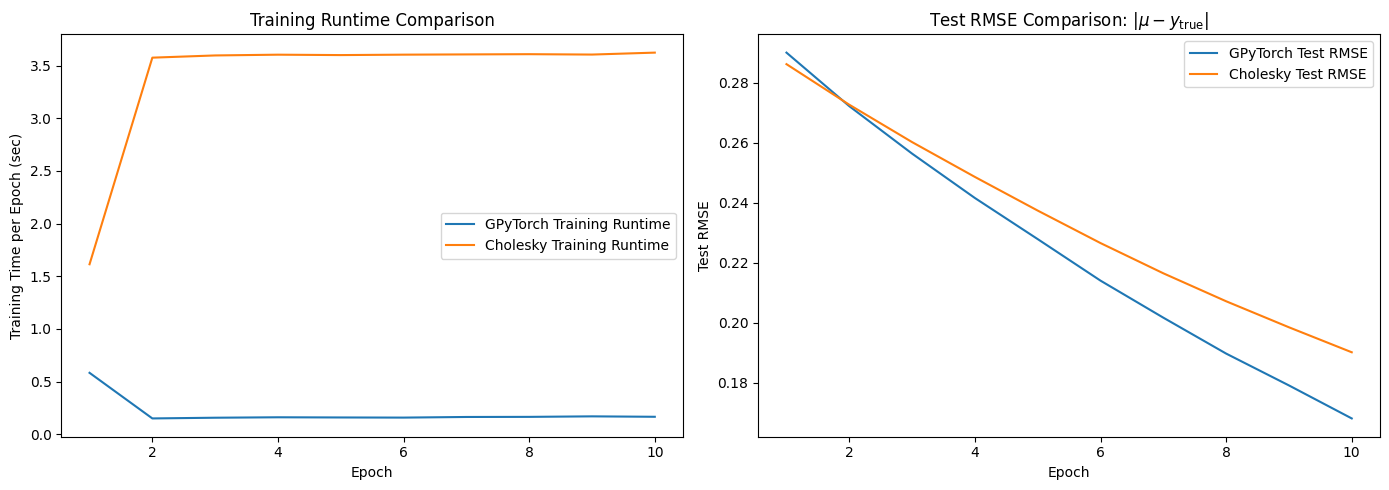

In [2]:
import time
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.backends.cuda.preferred_linalg_library(backend="cusolver")

def train_cholesky(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.01):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}
    ], lr=lr)
    
    runtime_log, test_rmse_log = [], []
    
    for i in tqdm(range(training_iterations), desc="Cholesky Training"):
        start_time = time.time()
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        loss.backward()    
        epoch_time = time.time() - start_time

        optimizer.step()
        mean, _ = model.predict(test_x)
        runtime_log.append(epoch_time)
        test_rmse = torch.mean(torch.abs(mean - test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f"[Cholesky] Iter {i+1}/{training_iterations}")
    
    return model, runtime_log, test_rmse_log


def train_gpytorch_model(model, likelihood, mll, optimizer, train_x, train_y, test_x, test_y, training_iterations=100):
    runtime_log, rmse_log = [], []
    #Per When are Iterative Gaussian Processes Reliably Accurate? Maddox et al 2021
    with gpytorch.settings.eval_cg_tolerance(1e-2), \
        gpytorch.settings.max_cg_iterations(100), \
        gpytorch.settings.cg_tolerance(1e-3),\
        gpytorch.settings.max_preconditioner_size(50), \
        gpytorch.settings.max_root_decomposition_size(5000), \
        gpytorch.settings.deterministic_probes(state=False), \
        gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=True, solves=True), \
        gpytorch.settings.num_trace_samples(16), \
        gpytorch.settings.skip_posterior_variances(state=False), \
        gpytorch.settings.fast_pred_var():
        for epoch in tqdm(range(training_iterations), desc="GPyTorch Training"):
            model.train()
            likelihood.train()

            start_time = time.time()
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            epoch_time = time.time() - start_time
            optimizer.step()

            runtime_log.append(epoch_time)

            with torch.no_grad():
                model.eval()
                likelihood.eval()
                with torch.no_grad(), gpytorch.settings.fast_pred_var():
                    observed_pred = likelihood(model(test_x))
                mean_pred = observed_pred.mean
                rmse = torch.mean(torch.abs(mean_pred - test_y)).item()
            rmse_log.append(rmse)

            if (epoch + 1) % 20 == 0:
                print(f"[GPyTorch] Epoch {epoch+1}/{training_iterations}, Time: {epoch_time:.4f} sec, RMSE: {rmse:.4f}")
    
    return runtime_log, rmse_log

training_iterations = 10
lr =.05
# Assume train_x, train_y, test_x, test_y are defined elsewhere
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_dtype = torch.float32

#============== Cholesky ==============
base_kernel = MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=GammaPrior(3.0, 6.0),
    nu=2.5
)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)
_, chol_runtime, chol_rmse = train_cholesky(
    cgp, train_x, train_y, test_x, test_y,
    training_iterations=training_iterations, lr=lr
)

#============== Iterative ==============
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=0.4).to(device)
base_kernel_gp = gpytorch.kernels.MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
    nu=2.5
).to(device)
kernel_gp = gpytorch.kernels.ScaleKernel(
    base_kernel_gp,
    outputscale_prior=gpytorch.priors.GammaPrior(2.0, 0.15)
).to(device)

gp_model = ExactGPModel(train_x, train_y, likelihood, kernel_gp).to(device)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)
optimizer = torch.optim.Adam(gp_model.parameters(), lr=lr)

gp_runtime, gp_rmse = train_gpytorch_model(
    gp_model, likelihood, mll, optimizer, train_x, train_y, test_x, test_y,
    training_iterations=training_iterations
)

#============== Plots ==============
epochs = np.arange(1, training_iterations + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, gp_runtime, label="GPyTorch Training Runtime")
axes[0].plot(epochs, chol_runtime, label="Cholesky Training Runtime")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training Time per Epoch (sec)")
axes[0].set_title("Training Runtime Comparison")
axes[0].legend()

axes[1].plot(epochs, gp_rmse, label="GPyTorch Test RMSE")
axes[1].plot(epochs, chol_rmse, label="Cholesky Test RMSE")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test RMSE")
axes[1].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[1].legend()

plt.tight_layout()
plt.show()

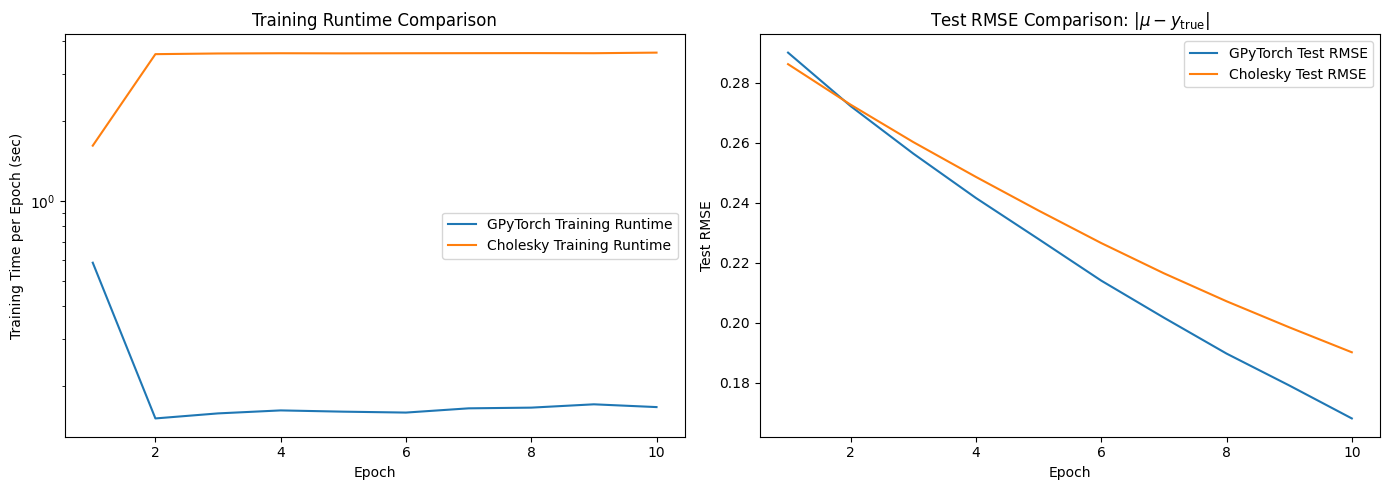

In [3]:
#============== Plots ==============
epochs = np.arange(1, training_iterations + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(epochs, gp_runtime, label="GPyTorch Training Runtime")
axes[0].plot(epochs, chol_runtime, label="Cholesky Training Runtime")
axes[0].set_xlabel("Epoch")
axes[0].set_yscale("log")
axes[0].set_ylabel("Training Time per Epoch (sec)")
axes[0].set_title("Training Runtime Comparison")
axes[0].legend()

axes[1].plot(epochs, gp_rmse, label="GPyTorch Test RMSE")
axes[1].plot(epochs, chol_rmse, label="Cholesky Test RMSE")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test RMSE")
axes[1].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# import time
# import torch
# import gpytorch
# import numpy as np
# import matplotlib.pyplot as plt
# from copy import deepcopy
# # Assume LBFGS is defined above as provided

# # Define a function for the combined pretraining and fine-tuning procedure.
# def pretrain_and_finetune_gp_model(model, likelihood, mll, full_train_x, full_train_y):
#     # Randomly select 10,000 training points for the subset.
#     num_subset = 10000
#     # Ensure reproducibility if needed
#     subset_indices = torch.randperm(full_train_x.size(0))[:num_subset]
#     train_x_subset = full_train_x[subset_indices]
#     train_y_subset = full_train_y[subset_indices]
    
#     # --- Phase 1: Pretraining with L-BFGS (10 steps) ---
#     # Here we use our custom LBFGS optimizer with a step size (learning rate) of 0.1.
#     lbfgs_optimizer = LBFGS(model.parameters(), lr=0.1)
#     print("Starting L-BFGS pretraining on subset...")
#     for i in range(10):
#         model.train()
#         likelihood.train()
#         # Define closure required for LBFGS.
#         def closure():
#             lbfgs_optimizer.zero_grad()
#             output = model(train_x_subset)
#             loss = -mll(output, train_y_subset)
#             loss.backward()
#             return loss
#         lbfgs_optimizer.step(closure)
#         print(f"L-BFGS step {i+1}/10 completed.")
    
#     # --- Phase 2: Pretraining with Adam on the subset (10 steps) ---
#     adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#     print("Starting Adam pretraining on subset...")
#     for i in range(10):
#         model.train()
#         likelihood.train()
#         adam_optimizer.zero_grad()
#         output = model(train_x_subset)
#         loss = -mll(output, train_y_subset)
#         loss.backward()
#         adam_optimizer.step()
#         print(f"Adam pretraining step {i+1}/10 completed.")
    
#     # --- Phase 3: Fine-tuning on the full training data (3 steps) ---
#     fine_tune_optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#     print("Starting fine-tuning on full training data...")
#     for i in range(3):
#         model.train()
#         likelihood.train()
#         fine_tune_optimizer.zero_grad()
#         output = model(full_train_x)
#         loss = -mll(output, full_train_y)
#         loss.backward()
#         fine_tune_optimizer.step()
#         print(f"Fine-tuning step {i+1}/3 completed.")
    
#     return model

# # ===================== Example usage =====================
# # Assume full_train_x, full_train_y, test_x, test_y are defined and on the correct device.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# global_dtype = torch.float32

# # Define the exact GP model (using your ExactGPModel) and likelihood as before.
# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=0.4).to(device)
# base_kernel_gp = gpytorch.kernels.MaternKernel(
#     ard_num_dims=train_x.shape[-1],
#     lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
#     nu=1.5
# ).to(device)
# kernel_gp = gpytorch.kernels.ScaleKernel(
#     base_kernel_gp,
#     outputscale_prior=gpytorch.priors.GammaPrior(2.0, 0.15)
# ).to(device)

# # Initialize the GP model with the full training data.
# gp_model = ExactGPModel(train_x, train_y, likelihood, kernel_gp).to(device)
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

# # Pretrain and fine-tune using the described procedure.
# gp_model = pretrain_and_finetune_gp_model(gp_model, likelihood, mll, train_x, train_y)

# # Optionally, evaluate on test data.
# gp_model.eval()
# likelihood.eval()
# with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     observed_pred = likelihood(gp_model(test_x))
# mean_pred = observed_pred.mean
# test_rmse = torch.mean(torch.abs(mean_pred - test_y)).item()
# print(f"Test RMSE after pretraining and fine-tuning: {test_rmse:.4f}")

In [ ]:
from gpytorch.distributions import MultivariateNormal

torch.backends.cuda.preferred_linalg_library(backend="cusolver")

def train_cholesky(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1, compute_nlpd=False):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log, mll_loss_log, test_rmse_log, nlpd_log = [], [], [], []
    
    for i in tqdm(range(training_iterations), desc="Cholesky Training"):
        start_time = time.time()
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        loss.backward()
        epoch_time = time.time() - start_time
        optimizer.step()

        mean, covar = model.predict(test_x)
        runtime_log.append(epoch_time)
        mll_loss_log.append(-loss.item())  # logging positive MLL values
        test_rmse = torch.mean(torch.abs(mean - test_y.to(mean.device))).item()
        test_rmse_log.append(test_rmse)

        if compute_nlpd:
            # Compute Negative Log Predictive Density (NLPD)
            pred_dist = MultivariateNormal(mean, covar)
            nlpd = gpytorch.metrics.negative_log_predictive_density(pred_dist, test_y.to(mean.device))
            nlpd_log.append(nlpd)
        else:
            nlpd_log.append(None)
        
        if (i + 1) % 20 == 0:
            print(f"[Cholesky] Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}")
    
    return model, runtime_log, mll_loss_log, test_rmse_log, nlpd_log

# -------------------------------
# GPyTorch Implementation (Iterative)
# -------------------------------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[-1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gpytorch(train_x, train_y, test_x, test_y, device, global_dtype, training_iterations=100, lr=0.01, compute_nlpd=False):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise=0.4).to(device)
    model = ExactGPModel(train_x, train_y, likelihood).to(device)

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    runtime_log, mll_log, rmse_log, nlpd_log = [], [], [], []

    for epoch in tqdm(range(training_iterations), desc="GPyTorch Training"):
        start_time = time.time()
        model.train()
        likelihood.train()
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        epoch_time = time.time() - start_time
        optimizer.step()

        runtime_log.append(epoch_time)
        mll_value = -loss.item()  # positive MLL
        mll_log.append(mll_value)

        # Switch to evaluation mode and predict.
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(test_x))
        mean_pred = observed_pred.mean
        rmse = torch.mean(torch.abs(mean_pred.detach().cpu() - test_y)).item()
        rmse_log.append(rmse)
        
        if compute_nlpd:
            # Compute NLPD using the observed predictive distribution.
            nlpd = gpytorch.metrics.negative_log_predictive_density(observed_pred, test_y)
            nlpd_log.append(nlpd)
        else:
            nlpd_log.append(None)

        if (epoch + 1) % 20 == 0:
            print(f"[GPyTorch] Epoch {epoch+1}/{training_iterations}, Time: {epoch_time:.4f} sec, Loss: {loss.item():.4f}, RMSE: {rmse:.4f}")

    # Clean up
    del model, likelihood, output, observed_pred
    torch.cuda.empty_cache()

    return runtime_log, mll_log, rmse_log, nlpd_log

# -------------------------------
# Main Comparison and Plotting
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_dtype = torch.float32

training_iterations = 100

# -------------------------------
# Run Cholesky-based GP training.
# -------------------------------
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1],
                           lengthscale_prior=GammaPrior(3.0, 6.0),
                           nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)

# Here, NLPD computation is optional (set compute_nlpd=True to enable)
_, chol_runtime, chol_mll, chol_rmse, chol_nlpd = train_cholesky(
    cgp, train_x, train_y, test_x, test_y,
    training_iterations=training_iterations, lr=0.1, compute_nlpd=False
)

# -------------------------------
# Run GPyTorch training.
# -------------------------------
gp_runtime, gp_mll, gp_rmse, gp_nlpd = train_gpytorch(
    train_x, train_y, test_x, test_y, device, global_dtype,
    training_iterations=training_iterations, lr=0.01, compute_nlpd=False
)

epochs = np.arange(1, training_iterations + 1)

# Plot comparison of training runtime, MLL, RMSE, and NLPD over epochs.
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(epochs, gp_runtime, label="GPyTorch Training Runtime")
axes[0, 0].plot(epochs, chol_runtime, label="Cholesky Training Runtime")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Training Time (sec)")
axes[0, 0].set_title("Training Runtime Comparison")
axes[0, 0].legend()

axes[0, 1].plot(epochs, gp_mll, label="GPyTorch MLL")
axes[0, 1].plot(epochs, chol_mll, label="Cholesky MLL")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[0, 1].set_title(r"MLL over Epochs: $-\mathcal{L}$")
axes[0, 1].legend()

axes[1, 0].plot(epochs, gp_rmse, label="GPyTorch Test RMSE")
axes[1, 0].plot(epochs, chol_rmse, label="Cholesky Test RMSE")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Test RMSE")
axes[1, 0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[1, 0].legend()

axes[1, 1].plot(epochs, gp_nlpd, label="GPyTorch NLPD")
axes[1, 1].plot(epochs, chol_nlpd, label="Cholesky NLPD")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Negative Log Predictive Density")
axes[1, 1].set_title("NLPD Comparison")
axes[1, 1].legend()

plt.tight_layout()
plt.show()